## 쉽게 해보는 image classification

https://arxiv.org/pdf/1409.1556.pdf
VGG 16을 직접 해보기

In [1]:
import keras
import cv2
from IPython.display import display, HTML
import base64

/home/mzza/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 본격적인  image classification 시작을 위한 데이터 처리
- 1.pascal 2012 데이터 다운로드 http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit
- 받은 데이터 압축을 풀어준다. Annotations  ImageSets  JPEGImages  SegmentationClass  SegmentationObject 폴더가 생성됨을 확인
- ImageSets/Main 에 각 클래스별 train/val/test 파일 이름이 들어있음 
- Classification을 위한 파일들을 JPEGImages에서 사용하면 된다

#### test 1. 이미지를 읽어와서 확인하기
#### 본인 이미지는 ~/data/VOCdevkit/VOC2012/JPEGImages 에 저장되어 있음

In [2]:
path_jpeg = '/home/mzza/data/VOCdevkit/VOC2012/JPEGImages/'

In [3]:
img = cv2.imread(path_jpeg+'2011_003210.jpg', 1)

In [4]:
#cv.imshow를 그대로 사용할 경우 jupyter notebook에서 crash 발생
def imshow(name, imageArray):
     _, png = cv2.imencode('.png', imageArray)
     encoded = base64.b64encode(png)
     return HTML(data='''<img alt="{0}" src="data:image/png;base64, {1}"/>'''.format(name, encoded.decode('ascii')))

imshow('test', img)

#### pascal voc image classification의 과제는 각 이미지(test) 마다 20개 클래스가 각각 어느 정도로 나타나는지를 수치화하여 제시하는 것

#### ex: 위의 사진은 사람 30, 소 0.1, .... (모든 클래스마다)

## 이미지 파일 정리하기

1. 분류를 위한 데이터를 train,val / test 로 구분하기
2. 각 이미지마다 20개의 클래스 라벨을 붙여 학습할 수 있도록 형태 지정하기

In [5]:
import os

In [10]:
path_dir = '/home/mzza/data/VOCdevkit/VOC2012/'
path_jpeg = '/home/mzza/data/VOCdevkit/VOC2012/JPEGImages/'

In [8]:
folder_list = os.listdir(path_dir)
imagelist_cls_dir = path_dir+'ImageSets/Main/'

In [13]:
imgelist = os.listdir(imagelist_cls_dir)

In [14]:
imgelist

['tvmonitor_trainval.txt',
 'person_val.txt',
 'boat_val.txt',
 'diningtable_test.txt',
 'cow_test.txt',
 'motorbike_val.txt',
 'aeroplane_trainval.txt',
 'bicycle_trainval.txt',
 'aeroplane_val.txt',
 'boat_train.txt',
 'cat_train.txt',
 'bus_test.txt',
 'tvmonitor_train.txt',
 'boat_test.txt',
 'dog_trainval.txt',
 'pottedplant_trainval.txt',
 'bird_test.txt',
 'sheep_val.txt',
 'dog_test.txt',
 'bird_train.txt',
 'motorbike_train.txt',
 'horse_train.txt',
 'sheep_trainval.txt',
 'person_test.txt',
 'pottedplant_val.txt',
 'pottedplant_train.txt',
 'bus_trainval.txt',
 'boat_trainval.txt',
 'pottedplant_test.txt',
 'sofa_train.txt',
 'cow_train.txt',
 'diningtable_val.txt',
 'chair_val.txt',
 'sofa_test.txt',
 'chair_trainval.txt',
 'cat_trainval.txt',
 'dog_train.txt',
 'tvmonitor_test.txt',
 'sofa_val.txt',
 'chair_train.txt',
 'sheep_train.txt',
 'cow_trainval.txt',
 'horse_test.txt',
 'diningtable_train.txt',
 'bottle_train.txt',
 'chair_test.txt',
 'bottle_trainval.txt',
 'motor

### 분류 이미지 목록을 보면 클래스별, trainval/ test로 나뉘어 있는 것을 확인할 수 있음

In [15]:
#class 목록 뽑기
class_list = list(set([x.split('_')[0] for x in imgelist]))
class_list.remove('test.txt')
class_list.remove('val.txt')
class_list.remove('train.txt')
class_list.remove('trainval.txt')

In [16]:
#20종의 클래스가 있음을 확인
print(class_list)
print(len(class_list))

['bus', 'person', 'pottedplant', 'train', 'tvmonitor', 'bicycle', 'chair', 'bottle', 'horse', 'cow', 'sofa', 'car', 'aeroplane', 'bird', 'motorbike', 'dog', 'boat', 'cat', 'diningtable', 'sheep']
20


In [17]:
#train/val , test 파일 목록 얻기
f = open(imagelist_cls_dir+'trainval.txt')
lines = f.readlines()
f.close()
traiin_val_list= [ x[:-1] for x in lines]
f = open(imagelist_cls_dir+'test.txt')
lines = f.readlines()
f.close()
test_list = [ x[:-1] for x in lines]
    


In [18]:
import pandas as pd

In [19]:
train_val_frame = pd.DataFrame(traiin_val_list, columns=['imgid'])
test_list_frame = pd.DataFrame(test_list, columns=['imgid'])

for x in class_list:
    file_each_class = open(imagelist_cls_dir+x+'_trainval.txt')
    w = file_each_class.readlines()
    class_det = pd.DataFrame([[x[:11],float(x[-3:])] for x in w],columns=['imgid',x])
    train_val_frame = pd.merge(train_val_frame, class_det, on='imgid')
    file_each_class.close()

### 이제 학습에 사용할 이미지 파일/ 이미지 파일의 클래스 라벨값을 한눈에 알아볼 수 있다
### 잘 됬을까 확인하기 위해 pascal voc 홈페이지의 명세와 데이터 프레임 내역을 대조해본다
그림 집어넣기 ( 맞음)

In [20]:
trainval_desc = pd.DataFrame([list(train_val_frame[x].value_counts()) for x in class_list], 
                             columns=['neg','pos','diff'],index=class_list).sort_index()
trainval_desc

,neg,pos,diff
aeroplane,10864,670,6
bicycle,10969,552,19
bird,10767,765,8
boat,11024,508,8
bottle,10772,706,62
bus,11110,421,9
car,10311,1161,68
cat,10456,1080,4
chair,10242,1119,179
cow,11231,303,6


### 분석용 데이터 준비 끝

## VGG 학습을 위한 데이터 사이즈 변환

In [21]:
row = 224
col = 224
def resize(img):
    img = cv2.imread(img)
    resize = cv2.resize(img,(row,col))
    return resize

In [22]:
import matplotlib.pyplot as plt

In [25]:
imshow('size',img)

### 변환하고 난 뒤 이미지 사이즈 변경을 확인할 수 있다

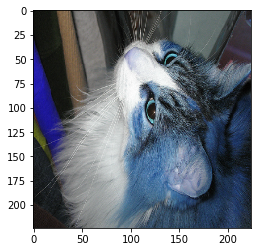

In [24]:
img = cv2.imread(path_jpeg+'2011_003211.jpg',1)
plt.imshow(cv2.resize(img,(row,col)))